# Dataset ARPA Lombardia
Registrazione delle misure recuperate dal database di ARPA Lombardia.
Sono fornite a risoluzione suboraria.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset con SCIA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|station_id|date|value|merged|variable|
|----------|----|-----|------|--------|
|utf8() |date()|double()|bool()|utf8()|
| fkey     |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [12]:
dataset_id <- "ARPALombardia"
state <- "Lombardia"


In [13]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == state)


## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [3]:
daily_dataset <- load_daily_data.arpal() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1845554,98.6,3400372,181.6,NA,3400372,181.6
Vcells,5874835,44.9,24478869,186.8,16384,24478869,186.8


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [4]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = TRUE)

checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1966163,105.1,3400372,181.6,NA,3400372,181.6
Vcells,6077964,46.4,41249897,314.8,16384,51561730,393.4


## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

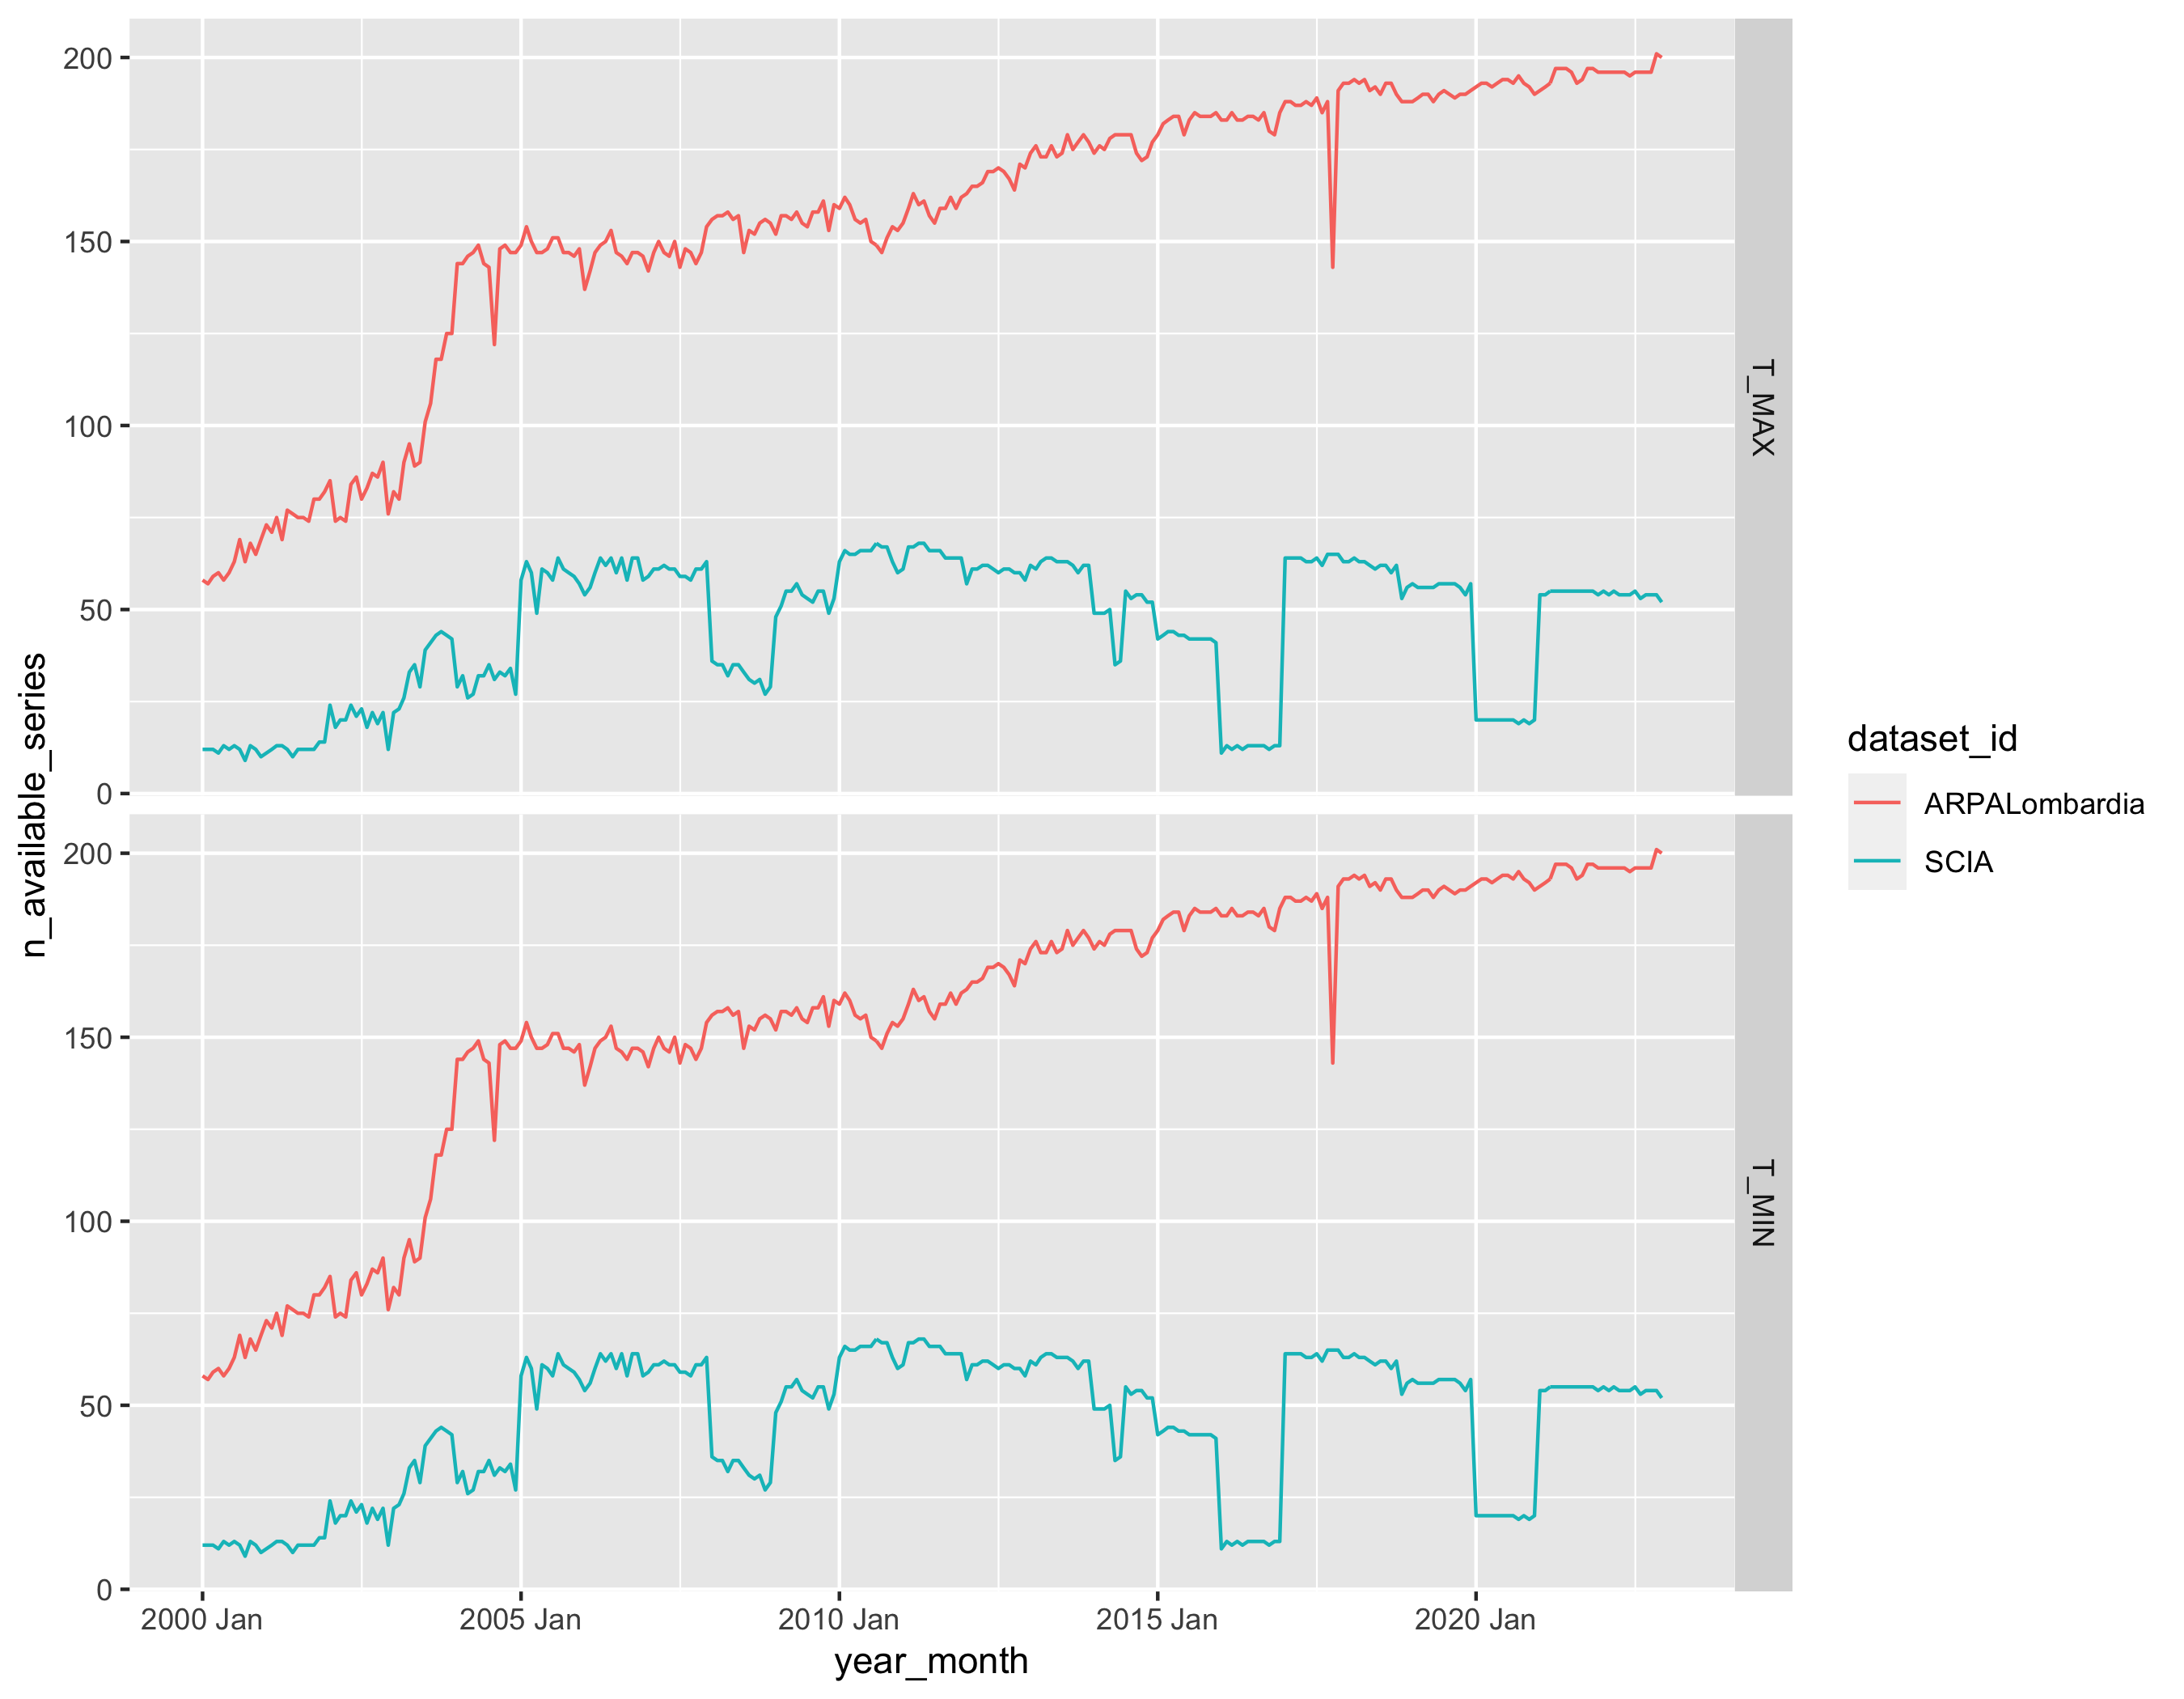

In [5]:
qc_database <- open_checkpoint(dataset_id, "qc1")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = "SCIA",
    region = state_boundaries,
    chkp_id = "qc1",
    start_date = first_date,
    end_date = last_date
)
p


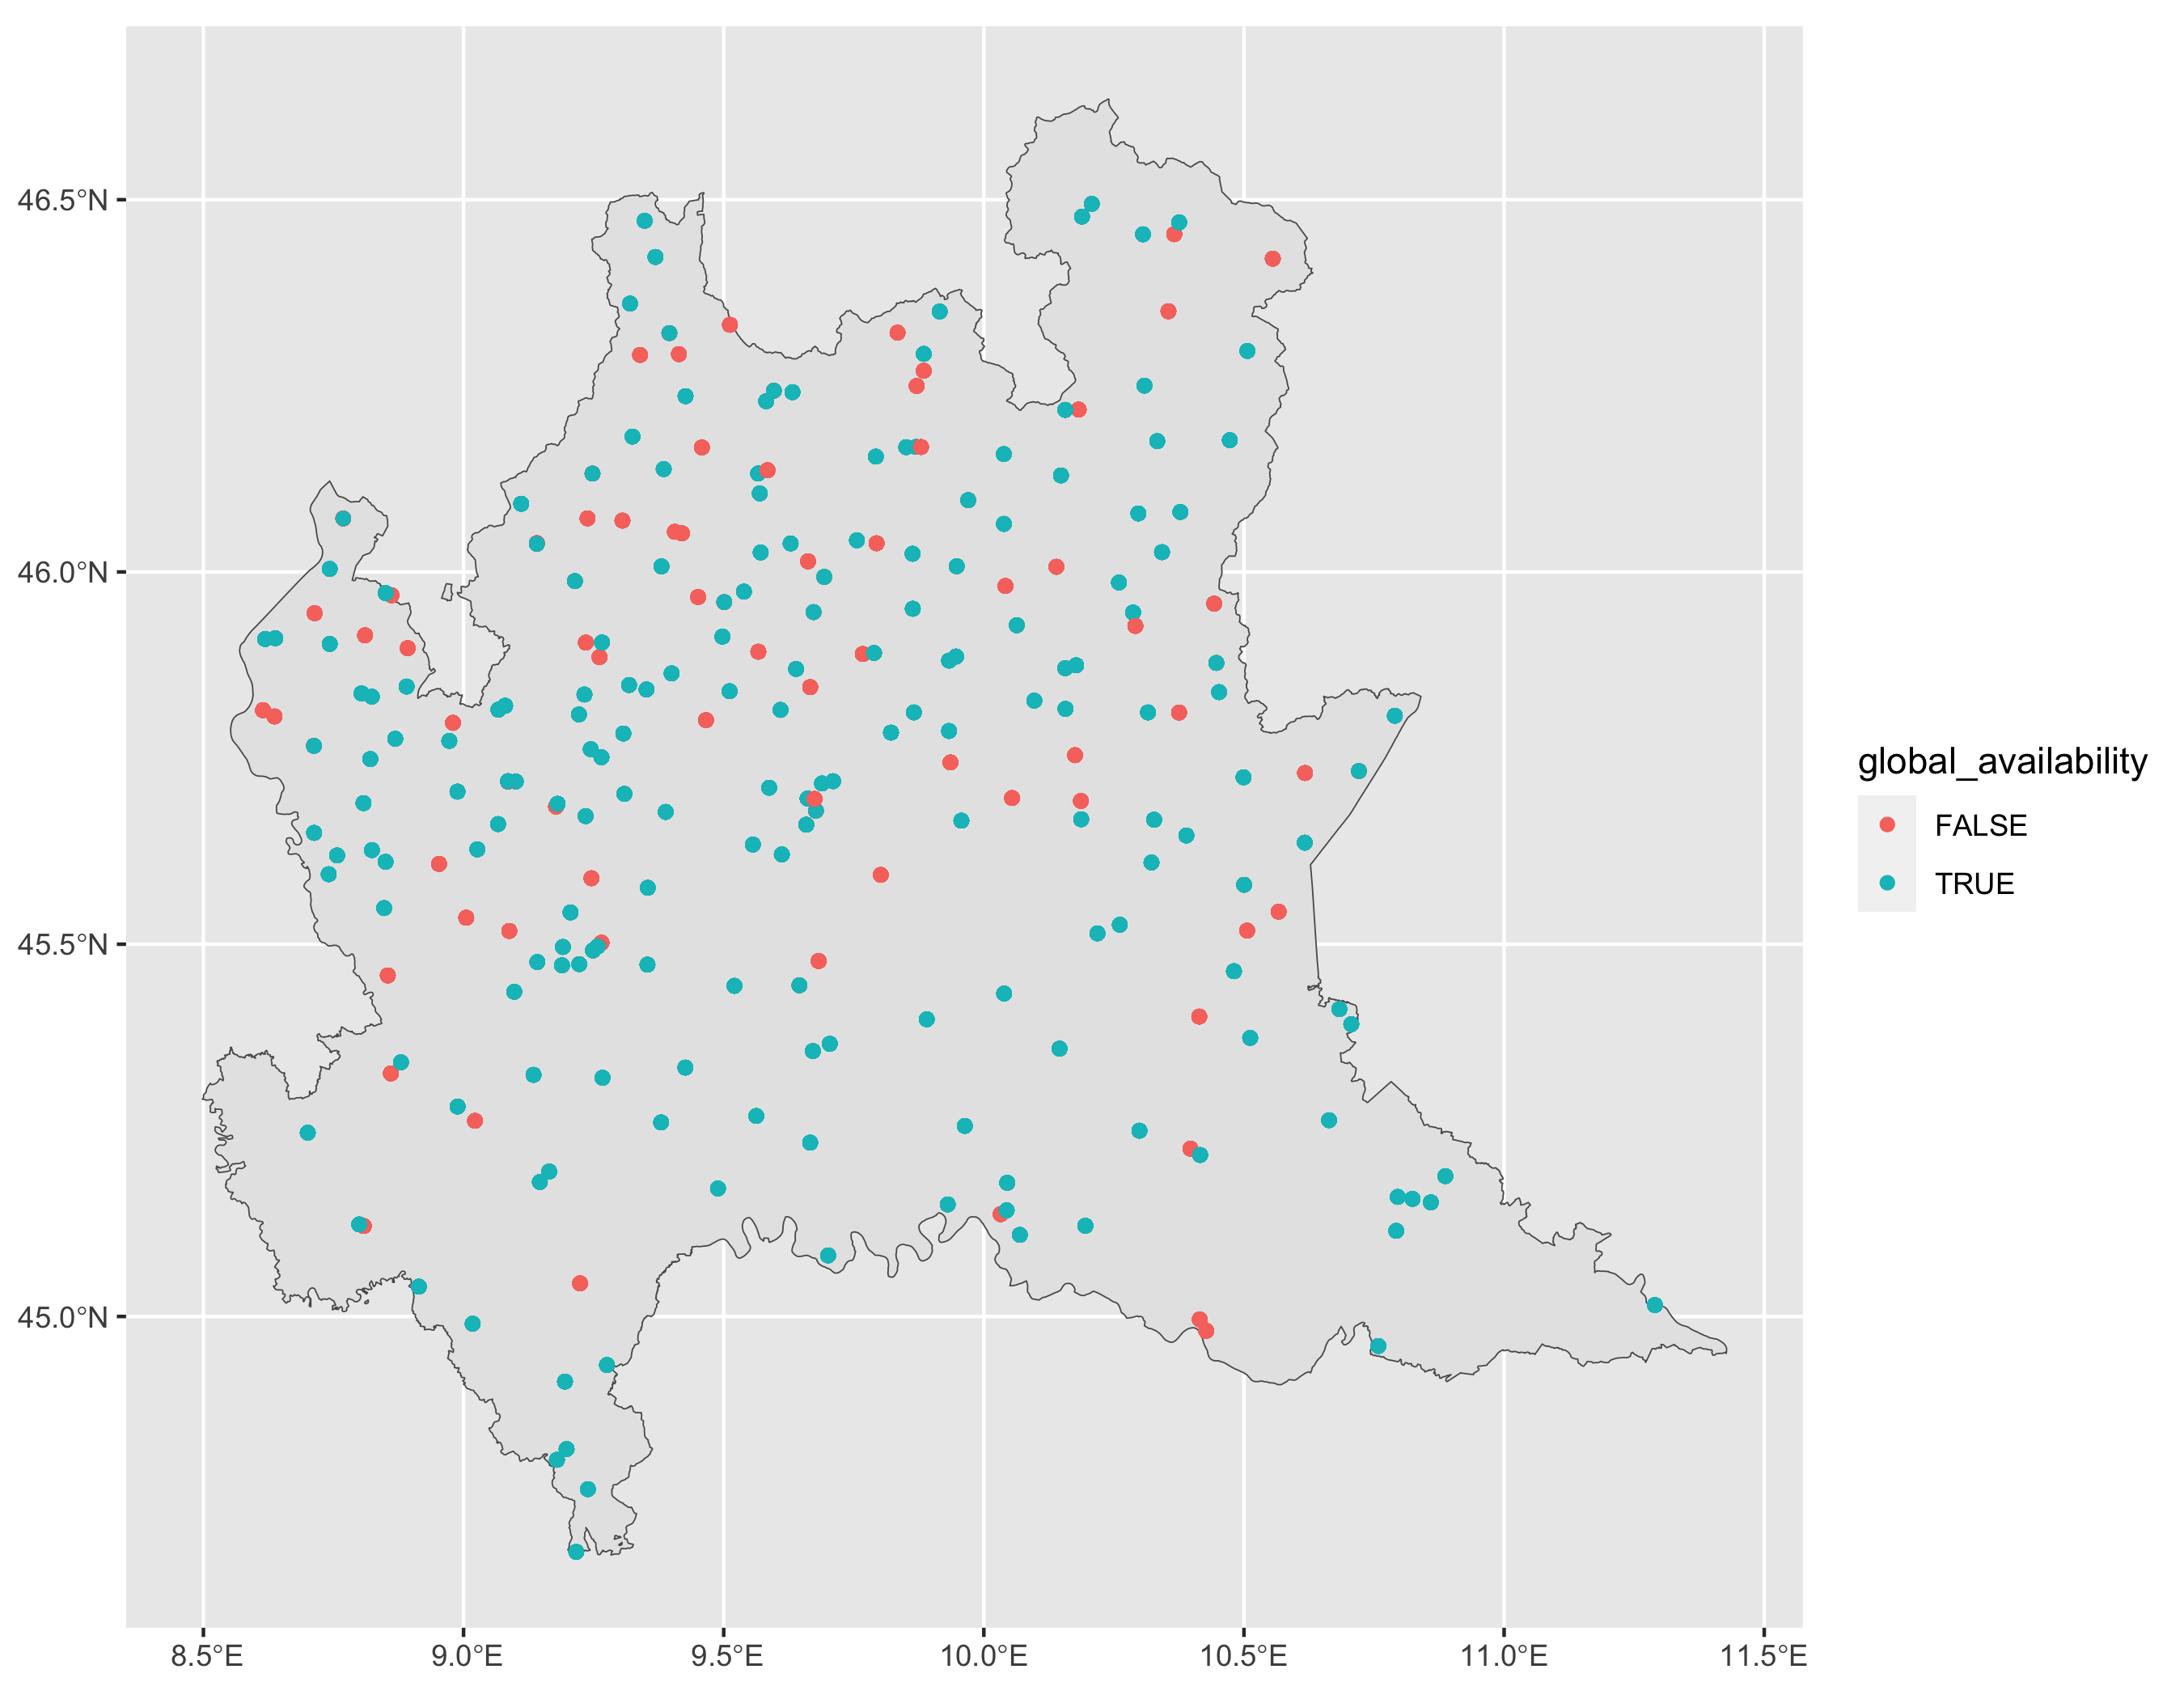

In [6]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail |> filter(dataset_id == !!dataset_id), qc_database$meta, state_boundaries)
p


In [7]:
rm(qc_database)
rm(ymonthly_avail)
rm(climats)
rm(p)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2244213,119.9,4970191,265.5,NA,4970191,265.5
Vcells,4743486,36.2,150427814,1147.7,16384,188032004,1434.6


## Merging
Gap-filling con altri dataset

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [6]:
qc_state <- open_checkpoint(dataset_id, "qc1")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries)
analysis_results <- perform_analysis(
    qc_state,
    qc_scia,
    dist_km = 6,
    first_date,
    last_date,
    str_to_lower(state)
)
rm(qc_state)
rm(qc_scia)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1982175,105.9,3581154,191.3,NA,3581154,191.3
Vcells,7669541,58.6,31152925,237.7,16384,40477774,308.9


In [7]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,47
FALSE,TRUE,125
FALSE,NA,48
TRUE,FALSE,154
TRUE,TRUE,26


station_id.x,n
<chr>,<int>
5e2f2818ad8e6d3eecf3d6fca544ab97,4
62e053d4decc0986807ad91cc2104004,4
7465b33434b1b71c6af9d8c606547725,4
90c5e58b4b6a1c9cf441c565937c2fd2,4
f25f2fc4a3a210881e38f8bf3b144e3b,4


station_id.y,n
<chr>,<int>
0490545aff317e407e42651db2883309,4
1490fc5f5e8c61cfe70dfb4a77505a08,4
2e872ddd60da3123cb2eb8ea676f0483,4
5489e1ae6d694605eaddfa50ce46af7c,4
5eba8ebb80d64511eeff2ec26b96a10d,4
692d6d38ac76239c48e242bfd850194f,4
80aaa4d517a856d917f669619011d69f,4
992d18ca5113501a11109af62cb1a114,4
a8d5e190f7f939f7e3c4fa53c7790bf5,4


In [8]:
combination_results <- build_combined_database(analysis_results)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")
rm(combination_results)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2054909,109.8,3581154,191.3,NA,3581154,191.3
Vcells,8847719,67.6,36028970,274.9,16384,45035405,343.6


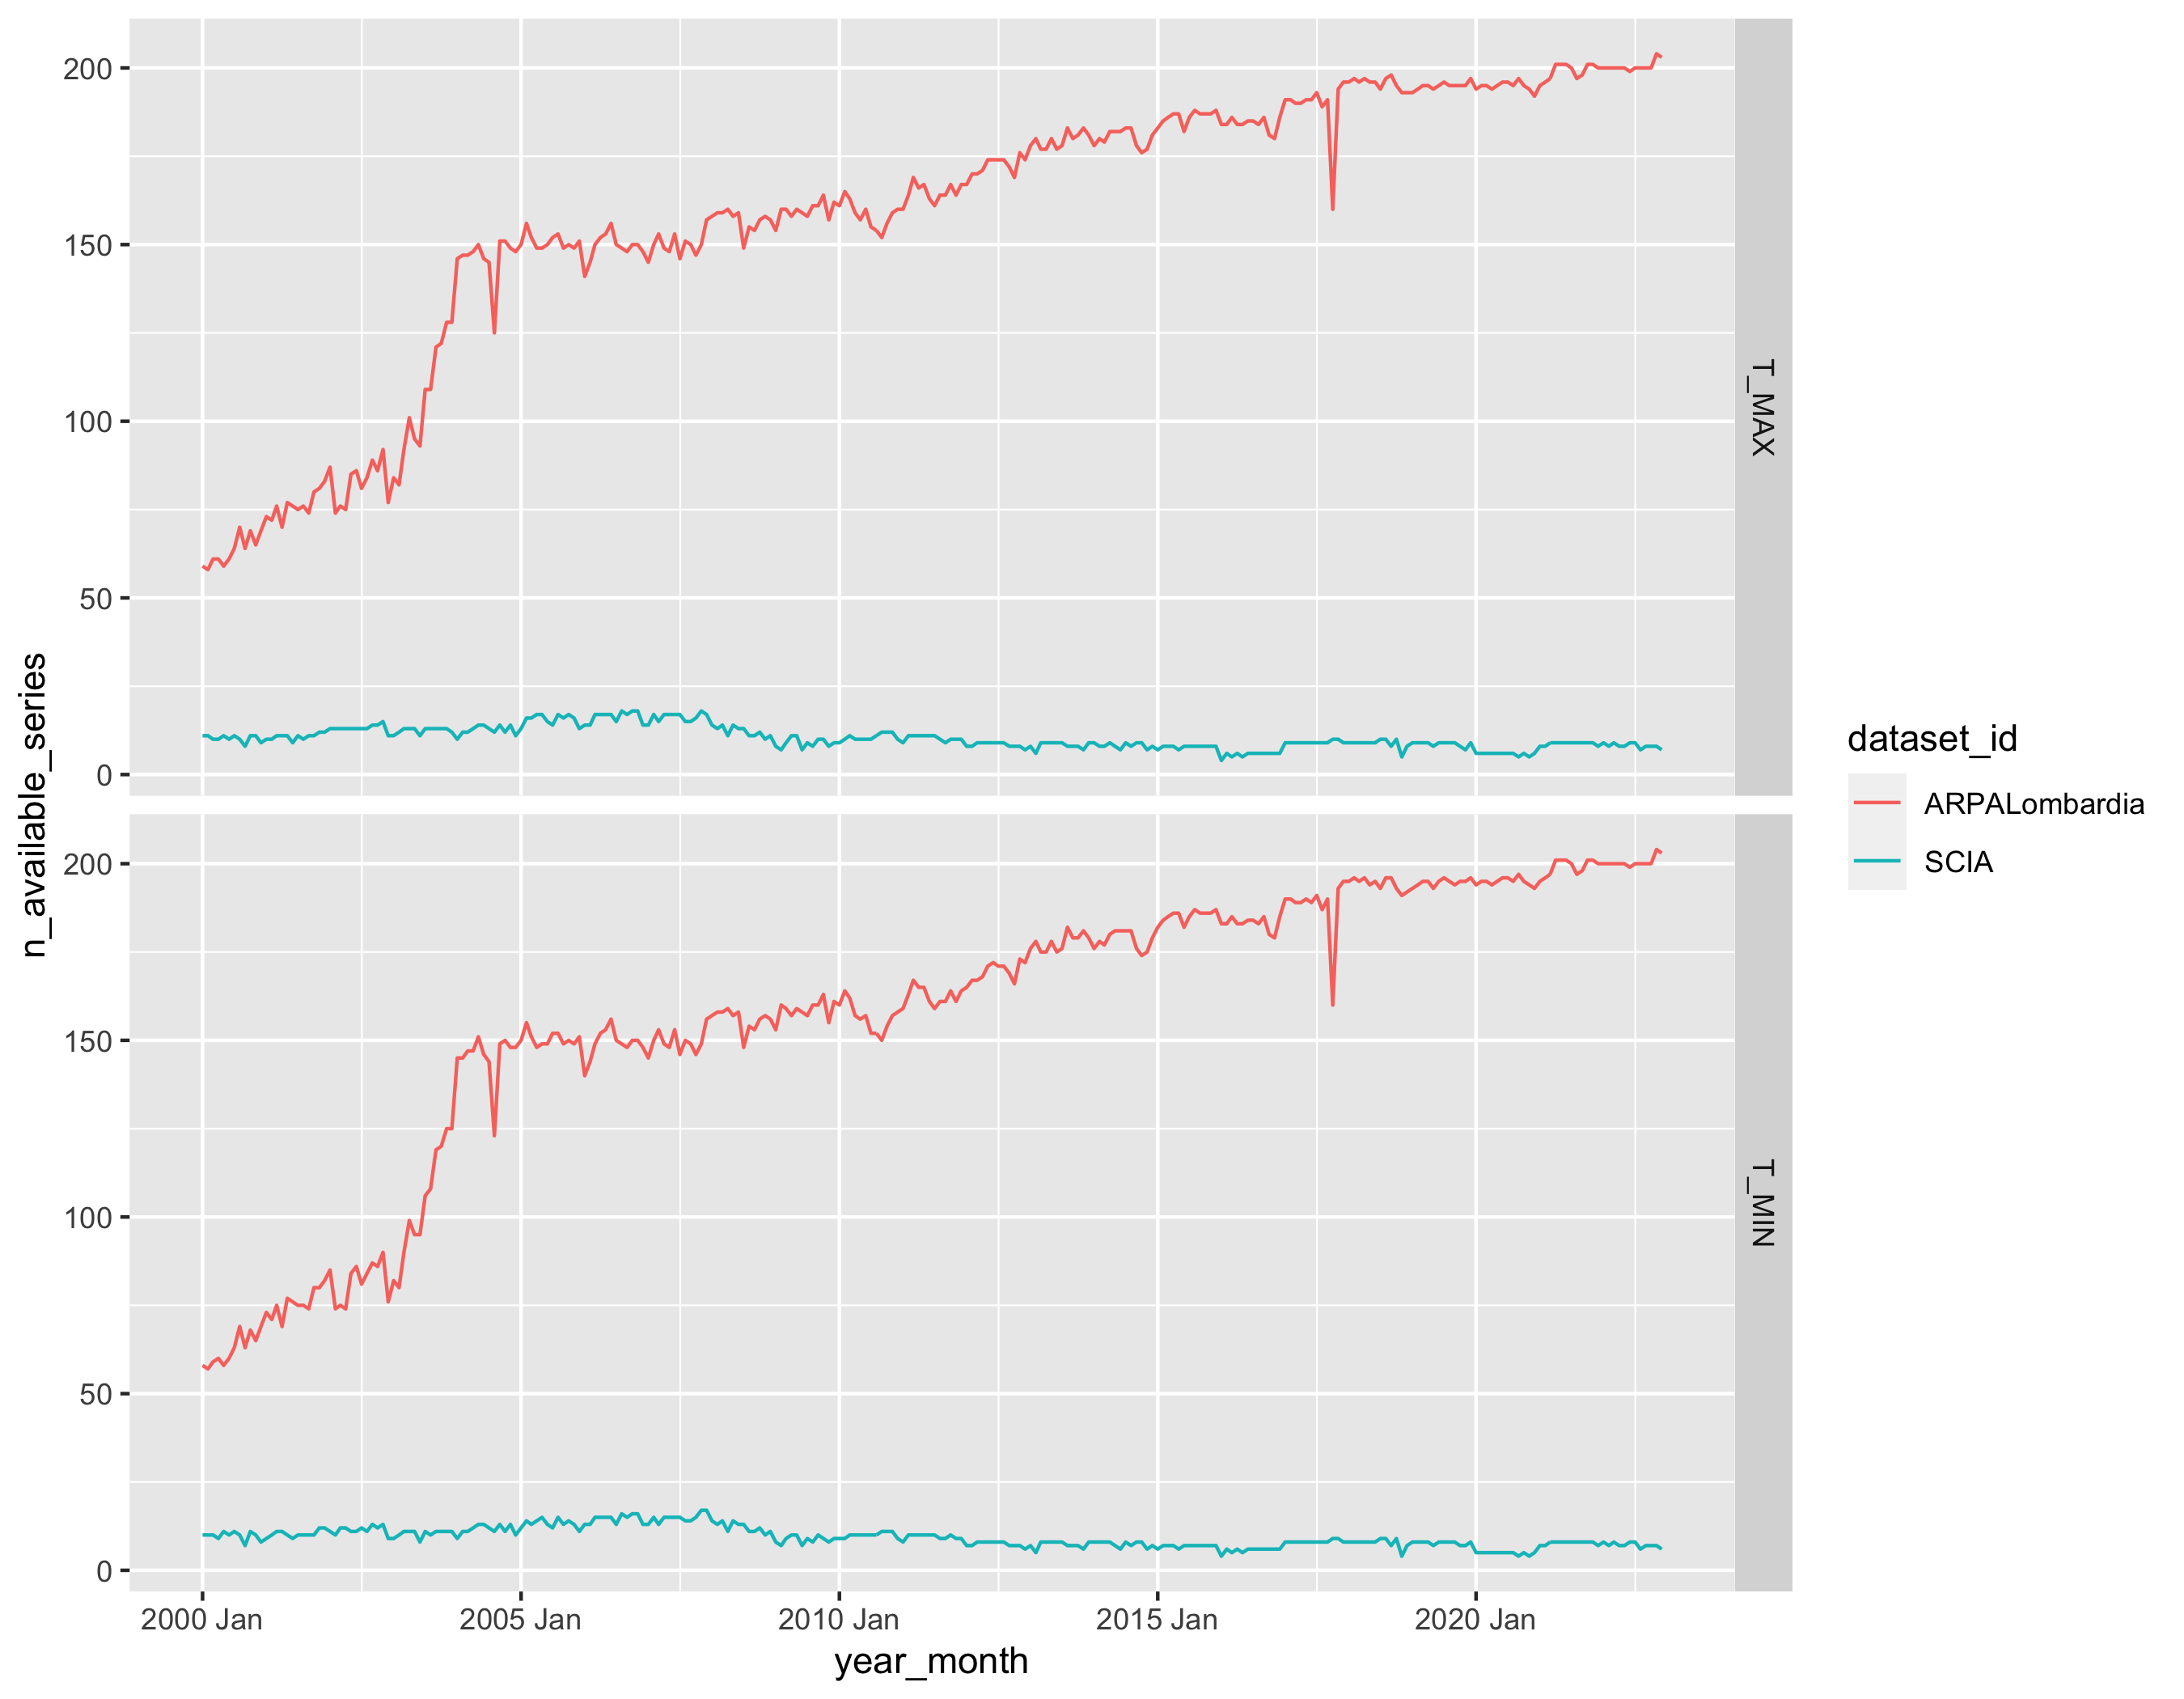

In [9]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


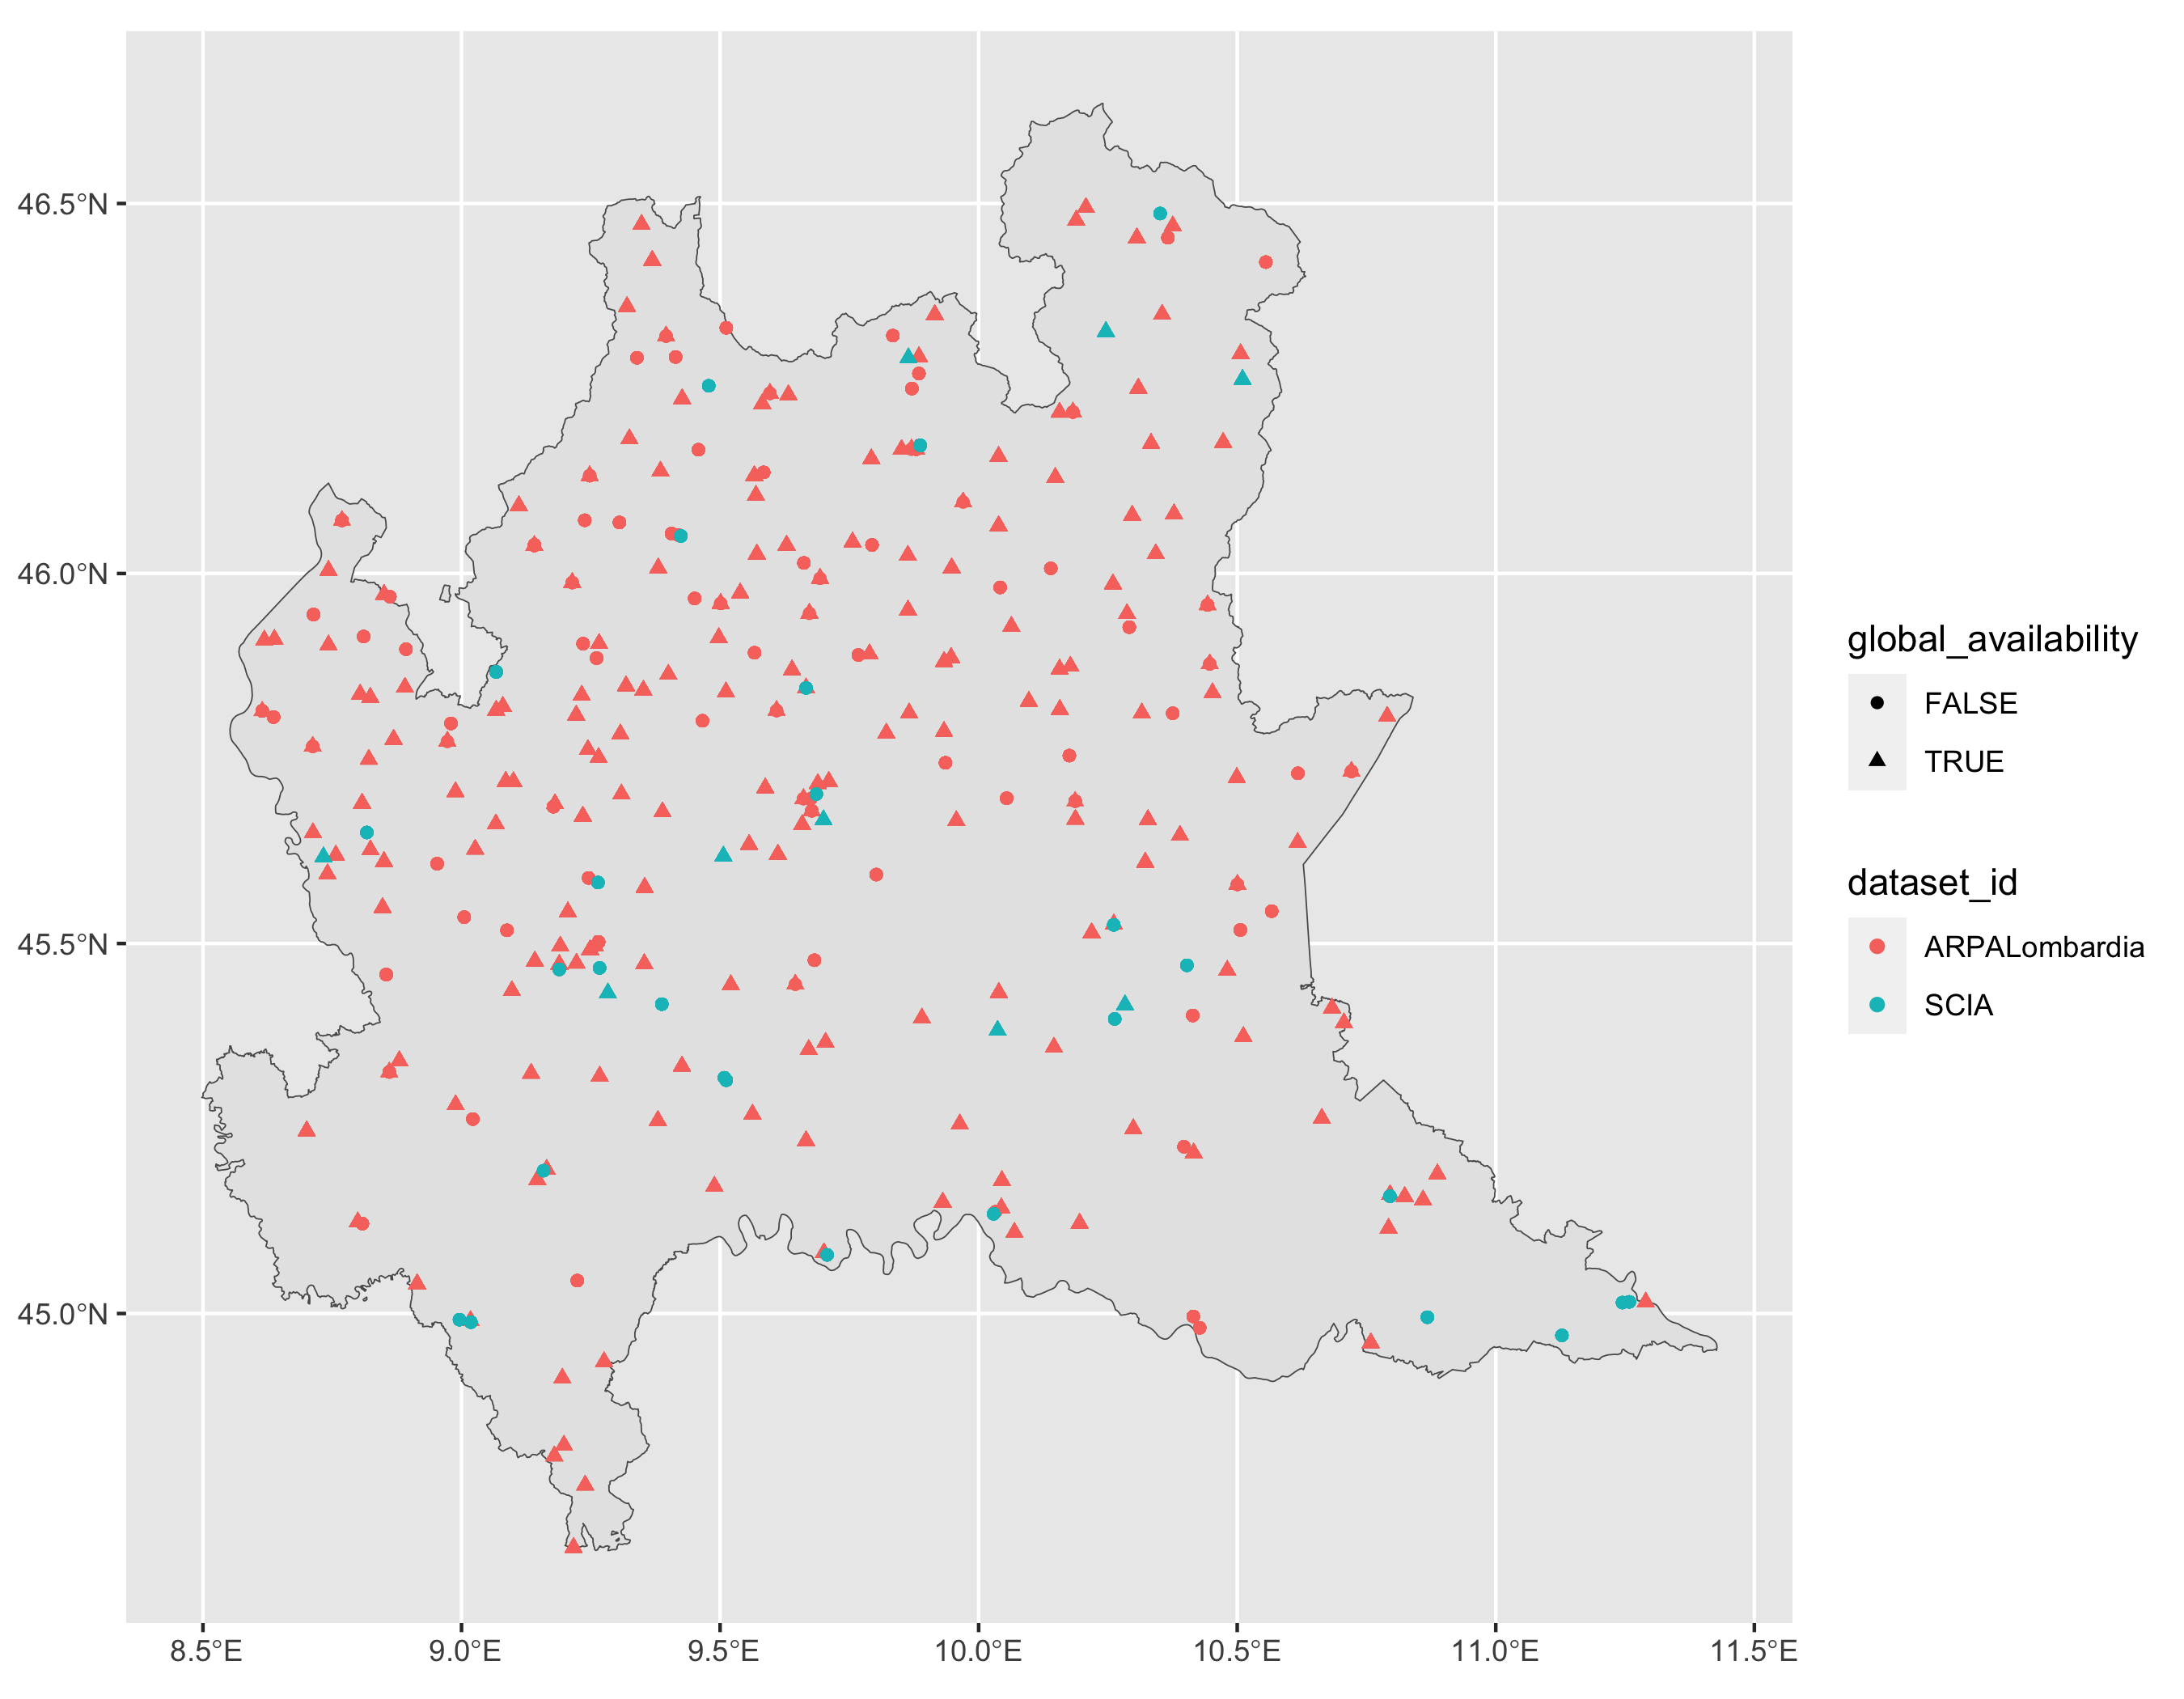

In [14]:
c(p, climats) %<-% spatial_availabilities(
    ymonthly_avail,
    combined_database$meta,
    state_boundaries
)
p


In [11]:
ymonthly_avail

dataset_id,station_id,variable,year_month,available
<chr>,<chr>,<chr>,<mth>,<lgl>
ARPALombardia,0313256b156e72ecfae4950da8393358,T_MAX,2000 Jan,FALSE
ARPALombardia,0313256b156e72ecfae4950da8393358,T_MAX,2000 Feb,FALSE
ARPALombardia,0313256b156e72ecfae4950da8393358,T_MAX,2000 Mar,FALSE
ARPALombardia,0313256b156e72ecfae4950da8393358,T_MAX,2000 Apr,FALSE
ARPALombardia,0313256b156e72ecfae4950da8393358,T_MAX,2000 May,FALSE
ARPALombardia,0313256b156e72ecfae4950da8393358,T_MAX,2000 Jun,FALSE
ARPALombardia,0313256b156e72ecfae4950da8393358,T_MAX,2000 Jul,FALSE
ARPALombardia,0313256b156e72ecfae4950da8393358,T_MAX,2000 Aug,FALSE
ARPALombardia,0313256b156e72ecfae4950da8393358,T_MAX,2000 Sep,FALSE


In [ ]:
rm(ymonthly_avail)
rm(climats)
gc()
